<div id="main image" align="center">
  <img src="agri_image.png" width="450" height="300" alt=""/>
</div>

# CO₂ Emissions on climate change from the Agri‑Food Sector

---
**Goal**: Analyze and predict yearly average temperature change from agri‑food emissions data.

**Data Source**: `co2_emissions_from_agri.csv`

## 1) Setup

In [34]:
# !pip install numpy

# !pip freeze > requirements.txt
!pip install -r requirements.txt

Looking in indexes: https://nexus.ny1.ninetyone.com/repository/pypy-all/simple


In [35]:
# Libraries for data loading, manipulation and analysis
import warnings
warnings.filterwarnings("ignore")

# Core imports
import pandas as pd
import numpy as np                              # 
import matplotlib.pyplot as plt                 # Visualisation - EDA
import seaborn as sns                           # Visualisation - EDA
import matplotlib.dates as mdates
import scipy.stats as st
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler            # Feature engineering - standardise the data because of variance
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV        # Modelling
from sklearn.pipeline import Pipeline           # Use Pipeline to cater for X_train Nan values

# Models
import pickle
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.graphics.correlation import plot_corr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

## 2) Load and validate data

In [36]:
df_raw = pd.read_csv("co2_emissions_from_agri.csv")
print("Shape:", df_raw.shape)
display(df_raw.head())

# Basic info & missingness
display(df_raw.describe(include='all').T)

display(df_raw.info())

display(df_raw.isna().sum().sort_values(ascending=False))



Shape: (6965, 31)


,Area,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Area,6965,236,Afghanistan,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,6965.0,NaN,NaN,NaN,2005.12491,8.894665,1990.0,1997.0,2005.0,2013.0,2020.0
Savanna fires,6934.0,NaN,NaN,NaN,1188.390893,5246.287783,0.0,0.0,1.65185,111.0814,114616.4011
Forest fires,6872.0,NaN,NaN,NaN,919.302167,3720.078752,0.0,0.0,0.5179,64.950775,52227.6306
Crop Residues,5576.0,NaN,NaN,NaN,998.706309,3700.34533,0.0002,11.006525,103.6982,377.640975,33490.0741
Rice Cultivation,6965.0,NaN,NaN,NaN,4259.666673,17613.825187,0.0,181.2608,534.8174,1536.64,164915.2556
Drained organic soils (CO2),6965.0,NaN,NaN,NaN,3503.228636,15861.445678,0.0,0.0,0.0,690.4088,241025.0696
Pesticides Manufacturing,6965.0,NaN,NaN,NaN,333.418393,1429.159367,0.0,6.0,13.0,116.325487,16459.0
Food Transport,6965.0,NaN,NaN,NaN,1939.58176,5616.748808,0.0001,27.9586,204.9628,1207.0009,67945.765
Forestland,6472.0,NaN,NaN,NaN,-17828.285678,81832.210543,-797183.079,-2848.35,-62.92,0.0,171121.076


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6472 non-null   float64
 10  Net Forest conversion            6472 non-null   float64
 11  Food Household Consumption       6492 non-null   float64
 12  Food Retail         

None

Crop Residues                      1389
On-farm energy use                  956
Manure Management                   928
Manure applied to Soils             928
IPPU                                743
Forestland                          493
Net Forest conversion               493
Food Household Consumption          473
Fires in humid tropical forests     155
Forest fires                         93
Savanna fires                        31
Drained organic soils (CO2)           0
Rice Cultivation                      0
Area                                  0
Year                                  0
Food Packaging                        0
On-farm Electricity Use               0
Food Retail                           0
Pesticides Manufacturing              0
Food Transport                        0
Food Processing                       0
Fertilizers Manufacturing             0
Agrifood Systems Waste Disposal       0
Fires in organic soils                0
Manure left on Pasture                0


Standard deviations are very high with majority of them being well above the mean

## 3) Cleaning and feature preparation

In [37]:
# Normalize column names (remove spaces/specials, keep a clean target name)
def clean_col(c):
    c = c.replace('°','').replace('(','').replace(')','')
    c = c.replace('-','_').replace(' ','_')
    c = c.replace('___','_').replace('__','_')
    return c
    
df_clean = df_raw.rename(columns={col: clean_col(col) for col in df_raw.columns})

df_clean.head()

df_clean = df_clean.fillna(df_clean.median(numeric_only=True))

# df_imputed.describe()

## 4) Exploratory Data Analysis (EDA)

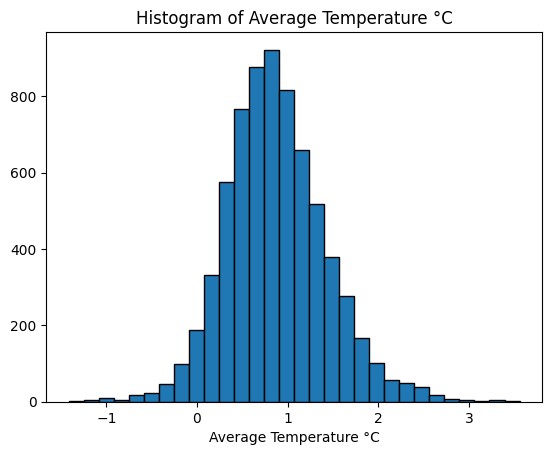

<Figure size 640x480 with 0 Axes>

In [ ]:
# Distribution of target
plt.hist(df_clean['Average_Temperature_C'], bins=30, edgecolor='black')
plt.title('Histogram of Average Temperature °C')
plt.xlabel('Average Temperature °C')
plt.show()

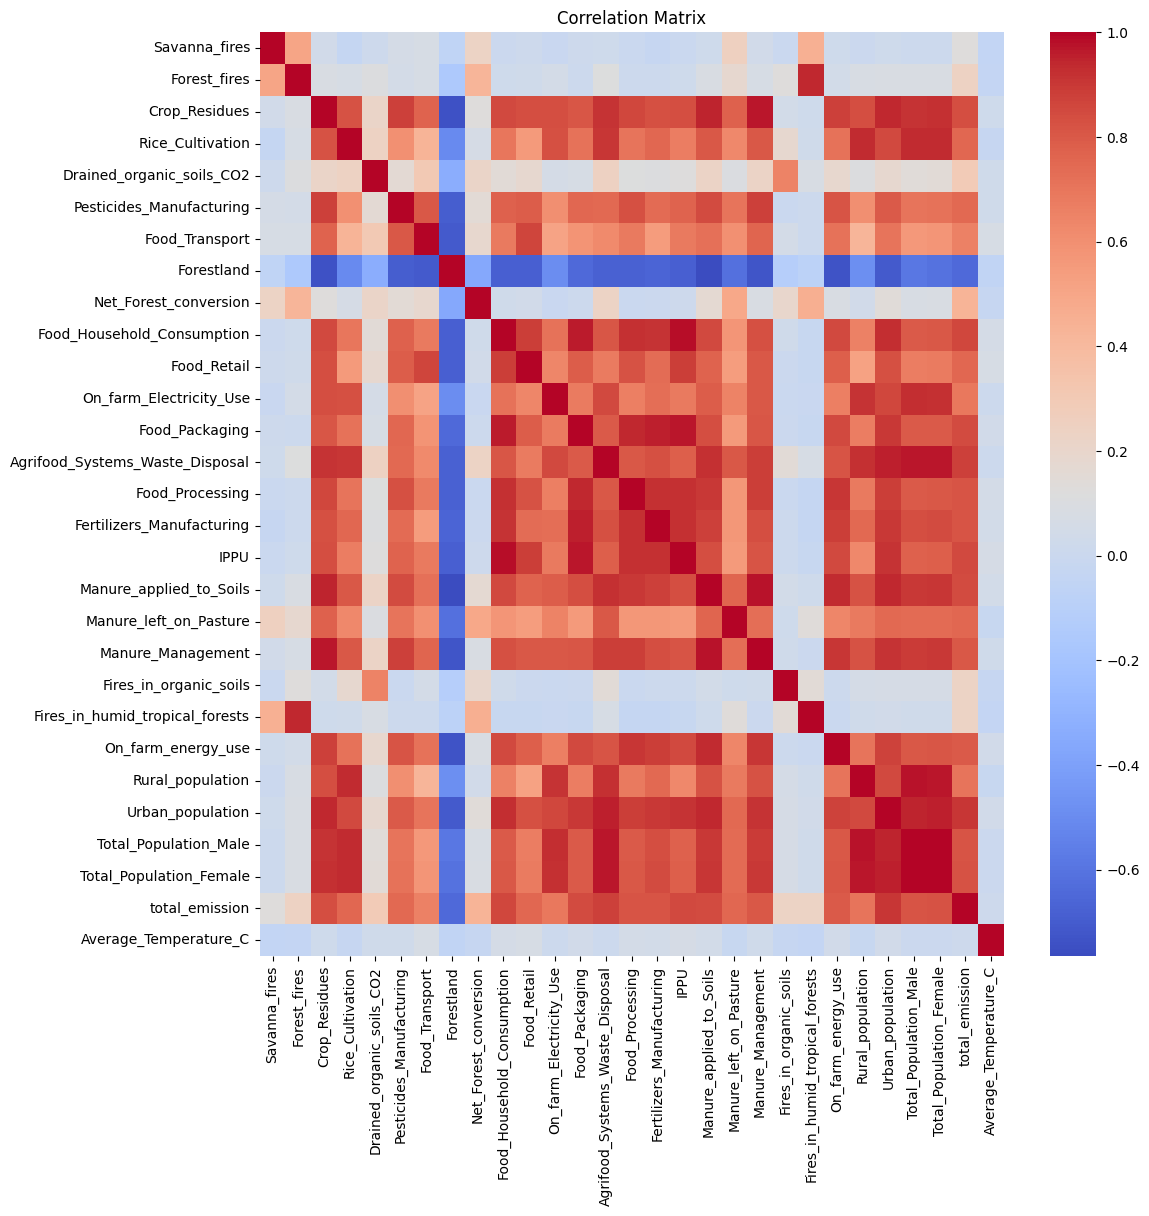

<Figure size 640x480 with 0 Axes>

In [ ]:
# Correlation heatmap for top-20 most variable numerical features
df_numeric = df_clean.select_dtypes(include='number').drop(columns=['Year'])
correlation_matrix = df_numeric.corr()
# Heatmap of the correlation matrix
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot = False,cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [40]:
# Calculate the numeric correlation coefficients
correlation_with_target = (correlation_matrix['Average_Temperature_C']).sort_values(ascending=False)
correlation_with_target

Average_Temperature_C              1.000000
Food_Transport                     0.075724
Food_Retail                        0.073404
IPPU                               0.062307
Food_Household_Consumption         0.055542
Food_Processing                    0.053083
Manure_applied_to_Soils            0.042268
Fertilizers_Manufacturing          0.041462
Food_Packaging                     0.040767
On_farm_energy_use                 0.039016
Urban_population                   0.036263
Manure_Management                  0.032698
Drained_organic_soils_CO2          0.029030
Pesticides_Manufacturing           0.027960
Crop_Residues                      0.025286
total_emission                     0.019043
On_farm_Electricity_Use            0.009081
Agrifood_Systems_Waste_Disposal    0.008995
Total_Population_Female            0.005456
Total_Population_Male              0.003623
Manure_left_on_Pasture            -0.015928
Rural_population                  -0.019764
Rice_Cultivation                

## 5) Train/validation split (time‑aware)

In [41]:
# Get train_test_split by year
def split_dataframe(df_year, X, y):
    years_sorted = np.sort(df_year['Year'].unique())
    if len(years_sorted) >= 5:
        # set threshold at 80th percentile year
        split_idx = int(len(years_sorted) * 0.8)
        year_threshold = years_sorted[split_idx]
        train_mask = df_year['Year'] < year_threshold
        test_mask = df_year['Year'] >= year_threshold
    else:
        # If too few distinct years, fallback to random split
        train_mask = np.random.RandomState(0).rand(len(df_year)) < 0.8
        test_mask = ~train_mask

    X_train, X_test = X.loc[train_mask, :], X.loc[test_mask, :]
    y_train, y_test = y.loc[train_mask], y.loc[test_mask]

    return X_train, y_train, X_test, y_test

In [42]:
# Create splits per Area to avoid leakage across time
def split_dataframe(df, X, y, years_holdout=3):
    train_idx, test_idx = [], []
    for area, g in df.groupby('Area'):
        if g['Year'].notna().sum() == 0:
            continue
        # last N years for test (if available)
        mask = g['Year'] >= (g['Year'].max() - years_holdout + 1)
        test_idx.extend(g[mask].index.tolist())
        train_idx.extend(g[~mask].index.tolist())

    X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    return X_train, y_train, X_test, y_test


## 6) Feature sets & transformers

Scale features to compare them

In [43]:
feature_cols = df_clean.select_dtypes(include='number').columns.tolist()

for col in ['Year']:
    if col in feature_cols:
        feature_cols.remove(col)
if 'Average_Temperature_C' in feature_cols:
    feature_cols.remove('Average_Temperature_C')

X = df_clean.select_dtypes(include='number').drop(columns=['Year']).loc[:, feature_cols]
# X = df_clean.loc[:, feature_cols]
y = df_clean['Average_Temperature_C']

# Identify strictly positive skewed columns for optional log1p
pos_cols = [c for c in feature_cols if (X[c] > 0).all() and X[c].skew() > 1.0]

# Apply log1p (log(1 + x)) transformation to those columns
X_log = X.copy()
X_log[pos_cols] = X_log[pos_cols].apply(np.log1p)


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, feature_cols)],
    remainder='drop'
)

#print(feature_cols)

## 7) Models

In [44]:
y = df_numeric['Average_Temperature_C']
X = df_numeric.drop(columns=['Average_Temperature_C'], errors="ignore")

model_OLS = sm.OLS(y,X)
model_OLS_result = model_OLS.fit()

alpha = 0.05
pvals = model_OLS_result.pvalues.drop(labels=["const"], errors="ignore").sort_values()
pvals = model_OLS_result.pvalues.sort_values()
pvals

Fertilizers_Manufacturing          1.799059e-112
Manure_left_on_Pasture              3.046103e-91
Food_Transport                      2.847903e-85
Rice_Cultivation                    4.230571e-80
Food_Retail                         7.223412e-80
Food_Household_Consumption          3.898796e-77
Fires_in_humid_tropical_forests     1.943296e-74
Food_Processing                     1.236110e-73
Drained_organic_soils_CO2           7.147088e-73
Forestland                          3.991206e-72
total_emission                      1.227242e-71
Net_Forest_conversion               4.073999e-71
Fires_in_organic_soils              1.322735e-70
Savanna_fires                       5.107730e-70
IPPU                                5.464165e-70
On_farm_Electricity_Use             6.757427e-70
Agrifood_Systems_Waste_Disposal     8.461433e-68
Forest_fires                        3.660686e-63
Manure_Management                   5.739810e-62
On_farm_energy_use                  1.125487e-59
Food_Packaging      

Check for multicollinearity

In [45]:
formula_str = 'Average_Temperature_C'+' ~ '+'+'.join(df_numeric.drop(columns="Average_Temperature_C").columns)
print(formula_str)

#Construct and fit the model using ols
model=smf.ols(formula=formula_str, data=df_numeric)
fitted = model.fit()

#Print the model summary
print(fitted.summary())

Average_Temperature_C ~ Savanna_fires+Forest_fires+Crop_Residues+Rice_Cultivation+Drained_organic_soils_CO2+Pesticides_Manufacturing+Food_Transport+Forestland+Net_Forest_conversion+Food_Household_Consumption+Food_Retail+On_farm_Electricity_Use+Food_Packaging+Agrifood_Systems_Waste_Disposal+Food_Processing+Fertilizers_Manufacturing+IPPU+Manure_applied_to_Soils+Manure_left_on_Pasture+Manure_Management+Fires_in_organic_soils+Fires_in_humid_tropical_forests+On_farm_energy_use+Rural_population+Urban_population+Total_Population_Male+Total_Population_Female+total_emission
                              OLS Regression Results                             
Dep. Variable:     Average_Temperature_C   R-squared:                       0.032
Model:                               OLS   Adj. R-squared:                  0.028
Method:                    Least Squares   F-statistic:                     8.065
Date:                   Sun, 07 Sep 2025   Prob (F-statistic):           3.29e-32
Time:             

Include Ridge and Lasso to cater for multicollinearity 

In [46]:
# ridge_param_grid = {"alpha": np.logspace(-3, 3, 25)}
# lasso_param_grid = {"alpha": np.logspace(-3, 3, 25)}
# rf_param_grid = {"n_estimators": [200], "max_depth": [None]}
# gbr_param_grid = {"n_estimators": [200],"max_depth": [None]}

# models = {
#     'LinearRegression': LinearRegression(),
#     # 'RidgeCV': RidgeCV(alphas=np.logspace(-3,3,25), cv=5),
#     # 'LassoCV': LassoCV(alphas=None, cv=5, random_state=RANDOM_STATE),
#     'RidgeCV': GridSearchCV(Ridge(random_state = RANDOM_STATE), ridge_param_grid, cv = 5, scoring="r2"),
#     'LassoCV': GridSearchCV(Lasso(random_state = RANDOM_STATE), lasso_param_grid, cv = 5, scoring="r2"),
#     'RandomForest': GridSearchCV(RandomForestRegressor(random_state = RANDOM_STATE), rf_param_grid, cv = 5, scoring="r2"),
#     'GradientBoosting': GridSearchCV(GradientBoostingRegressor(random_state = RANDOM_STATE), gbr_param_grid, cv = 5, scoring="r2")
# }

models = {
    'LinearRegression': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-3,3,25), cv=5),
    'LassoCV': LassoCV(alphas=None, cv=5, random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=800, random_state=RANDOM_STATE)
}


A function to evaluate the models

In [47]:
def fit_and_eval(name, model, X_train, y_train, X_test, y_test):
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return name, pipe, y_pred, r2, mse, rmse, mae

Run the model and rank the r2 scores

In [48]:
X_train, y_train, X_test, y_test = split_dataframe(df_clean, X, y)

results = []
preds_store = {}
fitted_models = {}
for name, model in models.items():
    nm, pipe, y_pred, r2, mse, rmse, mae = fit_and_eval(name, model, X_train, y_train, X_test, y_test)
    results.append({"Model": name, "R2_test": r2, "MSE_test": mse, "RMSE_test": rmse, "MAE_test": mae})
    preds_store[name] = y_pred
    fitted_models[name] = pipe

pd.DataFrame(results).sort_values('R2_test', ascending=False)

,Model,R2_test,MSE_test,RMSE_test,MAE_test
3,RandomForest,0.234218,0.245124,0.495100,0.374041
4,GradientBoosting,-0.002494,0.320895,0.566476,0.440780
1,RidgeCV,-1.045957,0.654903,0.809261,0.643916
0,LinearRegression,-1.056958,0.658425,0.811434,0.644427
2,LassoCV,-1.081887,0.666404,0.816336,0.647574


Run the model with the log values and rank the r2 scores

In [49]:
# Try modelling with the log value
X_train, y_train, X_test, y_test = split_dataframe(df_clean, X_log, y)

results_log = []
preds_store_log = {}
fitted_models_log = {}
for name, model in models.items():
    nm, pipe, y_pred, r2, mse, rmse, mae = fit_and_eval(name, model, X_train, y_train, X_test, y_test)
    results_log.append({"Model": name, "R2_test": r2, "MSE_test": mse, "RMSE_test": rmse, "MAE_test": mae})
    preds_store_log[name] = y_pred
    fitted_models_log[name] = pipe

pd.DataFrame(results_log).sort_values('R2_test', ascending=False)

,Model,R2_test,MSE_test,RMSE_test,MAE_test
3,RandomForest,0.233600,0.245322,0.495300,0.374262
4,GradientBoosting,-0.002426,0.320873,0.566457,0.440782
0,LinearRegression,-0.879553,0.601638,0.775653,0.628000
2,LassoCV,-0.920337,0.614693,0.784024,0.628141
1,RidgeCV,-0.922738,0.615462,0.784514,0.629124


In [50]:
df_clean

,Area,Year,Savanna_fires,Forest_fires,Crop_Residues,Rice_Cultivation,Drained_organic_soils_CO2,Pesticides_Manufacturing,Food_Transport,Forestland,...,Manure_Management,Fires_in_organic_soils,Fires_in_humid_tropical_forests,On_farm_energy_use,Rural_population,Urban_population,Total_Population_Male,Total_Population_Female,total_emission,Average_Temperature_C
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.0000,0.0,11.807483,63.1152,-2388.8030,...,319.1763,0.0,0.0,141.0963,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.1600,0.0,11.712073,61.2125,-2388.8030,...,342.3079,0.0,0.0,141.0963,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.0000,0.0,11.712073,53.3170,-2388.8030,...,349.1224,0.0,0.0,141.0963,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.0000,0.0,11.712073,54.3617,-2388.8030,...,352.2947,0.0,0.0,141.0963,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.6000,0.0,11.712073,53.9874,-2388.8030,...,367.6784,0.0,0.0,141.0963,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6960,Zimbabwe,2016,1190.0089,232.5068,70.9451,7.4088,0.0,75.000000,251.1465,76500.2982,...,282.5994,0.0,0.0,417.3150,10934468.0,5215894.0,6796658.0,7656047.0,98491.026347,1.120250
6961,Zimbabwe,2017,1431.1407,131.1324,108.6262,7.9458,0.0,67.000000,255.7975,76500.2982,...,255.5900,0.0,0.0,398.1644,11201138.0,5328766.0,6940631.0,7810471.0,97159.311553,0.046500
6962,Zimbabwe,2018,1557.5830,221.6222,109.9835,8.1399,0.0,66.000000,327.0897,76500.2982,...,257.2735,0.0,0.0,465.7735,11465748.0,5447513.0,7086002.0,7966181.0,97668.308205,0.516333
6963,Zimbabwe,2019,1591.6049,171.0262,45.4574,7.8322,0.0,73.000000,290.1893,76500.2982,...,267.5224,0.0,0.0,444.2335,11725970.0,5571525.0,7231989.0,8122618.0,98988.062799,0.985667


In [51]:
def calculate_vif(df):
    """
    Calculates VIF for each feature in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing only the independent variables.

    Returns:
    - pd.DataFrame: A DataFrame with features and their corresponding VIF values.
    """
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                       for i in range(df.shape[1])]

    return vif_data

In [52]:
vif_result_scaled = calculate_vif(df_numeric)

In [53]:
vif_result_scaled

,Feature,VIF
0,Savanna_fires,216.130276
1,Forest_fires,119.527351
2,Crop_Residues,143.462923
3,Rice_Cultivation,2311.563878
4,Drained_organic_soils_CO2,1928.056967
5,Pesticides_Manufacturing,28.118484
6,Food_Transport,259.697772
7,Forestland,47410.398432
8,Net_Forest_conversion,71381.310297
9,Food_Household_Consumption,4726.983419


The VIF results are high and need to be scaled

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_normalize = pd.DataFrame(X_scaled, columns=X.columns)

X_train, y_train, X_test, y_test = split_dataframe(df_clean, X_normalize, y)

results_log = []
preds_store_log = {}
fitted_models_log = {}
for name, model in models.items():
    nm, pipe, y_pred, r2, mse, rmse, mae = fit_and_eval(name, model, X_train, y_train, X_test, y_test)
    results_log.append({"Model": name, "R2_test": r2, "MSE_test": mse, "RMSE_test": rmse, "MAE_test": mae})
    preds_store_log[name] = y_pred
    fitted_models_log[name] = pipe

pd.DataFrame(results_log).sort_values('R2_test', ascending=False)

,Model,R2_test,MSE_test,RMSE_test,MAE_test
3,RandomForest,0.233999,0.245194,0.495171,0.374044
4,GradientBoosting,-0.011188,0.323678,0.568927,0.443147
1,RidgeCV,-1.045957,0.654903,0.809261,0.643916
0,LinearRegression,-1.056958,0.658425,0.811434,0.644427
2,LassoCV,-1.081887,0.666404,0.816336,0.647574


## 8) Important model and feature

In [55]:
best_name = pd.DataFrame(results).sort_values('R2_test', ascending=False).iloc[0]['Model']
best = fitted_models[best_name]
print('Best model:', best_name)

r = permutation_importance(best, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
imp = pd.DataFrame({'feature': feature_cols, 'importance': r.importances_mean}).sort_values('importance', ascending=False)
imp.head(25)

Best model: RandomForest


,feature,importance
10,Food_Retail,0.786481
18,Manure_left_on_Pasture,0.241688
21,Fires_in_humid_tropical_forests,0.199030
6,Food_Transport,0.154895
16,IPPU,0.131676
3,Rice_Cultivation,0.130119
4,Drained_organic_soils_CO2,0.127499
7,Forestland,0.126996
11,On_farm_Electricity_Use,0.122730
15,Fertilizers_Manufacturing,0.118989


Try bootstap aggregation on important fields

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = df_clean[['Food_Retail', 'Manure_left_on_Pasture', 'Fires_in_humid_tropical_forests', 'Food_Transport']]
y = df_clean['Average_Temperature_C']

predictions = []
n_bootstrap_samples = 100
results_boot = []
fitted_models_boot = {}

for name, model in models.items():
    for _ in range(n_bootstrap_samples):
        X_sample, y_sample = resample(X, y)
        model = model
        model.fit(X_sample, y_sample)
        y_pred = model.predict(X)
        predictions.append(y_pred)

    bagged_prediction = np.mean(predictions, axis=0)

    fitted_models_boot[name] = model

    r2_bagged = r2_score(y, bagged_prediction)
    mse_bagged = mean_squared_error(y, bagged_prediction)
    rmse_bagged = math.sqrt(mse)
    mae_bagged = mean_absolute_error(y, bagged_prediction)

    fitted_models_boot[name] = model
    results_boot.append({"Model": name, "R2_test": r2_bagged, "MSE_test": mse_bagged, "RMSE_test": rmse_bagged, "MAE_test": mae_bagged})
   
pd.DataFrame(results_boot).sort_values('R2_test', ascending=False)

,Model,R2_test,MSE_test,RMSE_test,MAE_test
4,GradientBoosting,0.369424,0.194856,0.568927,0.337102
3,RandomForest,0.309831,0.213271,0.568927,0.353778
1,RidgeCV,0.012630,0.305110,0.568927,0.426117
2,LassoCV,0.012630,0.305110,0.568927,0.426128
0,LinearRegression,0.012626,0.305112,0.568927,0.426091


## 9) Save best model

In [23]:

# Assume 'model' is your trained regression model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)
